In [10]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from ncon import ncon

global ny, N
ny = 8 # unit cell number in y direction
N = 2*ny
# a1 = np.sqrt(3)/(2) # a = 1, a1 = a*sqrt(3)/2
    
def NB(T, E):
    # Bose distribution
    E = np.real(E)
    if abs(E/T) > 500:
        return 0
    else: return 1/(np.exp(E/T) - 1) 

def eigenv(H):
    '''  setup eigenvalues and eigenvectors
    parameters:
        H: np.ndarray
            Hamiltonian matrix
    returns:
        E: list
            eigenvalues
        U: np.ndarray
            eigenvectors
            U[i, m]: i: sites, m: energy
        U_dag: np.ndarray
            conjugate transpose of U
    '''
    
    E, U = linalg.eigh(H)
    U_dag = np.conjugate(U).T
    
    return E, U, U_dag

In [ ]:
def hamiltonian_0(j, J, d, h, k, obc=True):
    ''' H in A, B basis
    '''
    
    S = 0.5
    j, J, d = j*S, J*S, d*S
    
    ni = lambda i: i % N
    mat = np.zeros((N, N), dtype=np.complex128)
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)
        
    ''' Periodic boundary condition '''

    for i in A:
        
        mat[i, i] += 3*j + 6*J + h
        
        # nearest neighbors
        mat[i, ni(i+1)] += -2*j*np.cos(k)
        mat[i, ni(i-1)] += -j
        
        # next nearest neighbors
        mat[i, i] += -2*J*np.cos(2*k)
        mat[i, ni(i+2)] += -J*np.cos(k)
        mat[i, ni(i-2)] += -J*np.cos(k)
        mat[ni(i-2), i] += -J*np.cos(k)
        mat[ni(i+2), i] += -J*np.cos(k)
        # DMI
        mat[i, i] += -2*d*np.sin(2*k)
        mat[i, ni(i+2)] += d*np.sin(k)
        mat[i, ni(i-2)] += d*np.sin(k)
        mat[ni(i-2), i] += d*np.sin(k)
        mat[ni(i+2), i] += d*np.sin(k)
        
    for i in B:
        
        mat[i, i] = 3*j + 6*J + h
        
        # nearest neighbors
        mat[i, ni(i-1)] += -2*j*np.cos(k)
        mat[i, ni(i+1)] += -j
        
        # next nearest neighbors
        mat[i, i] += -2*J*np.cos(2*k)
        mat[i, ni(i+2)] += -J*np.cos(k)
        mat[i, ni(i-2)] += -J*np.cos(k)
        mat[ni(i-2), i] += -J*np.cos(k)
        mat[ni(i+2), i] += -J*np.cos(k)
        # DMI
        mat[i, i] += 2*d*np.sin(2*k)
        mat[i, ni(i+2)] += -d*np.sin(k)
        mat[i, ni(i-2)] += -d*np.sin(k)
        mat[ni(i-2), i] += -d*np.sin(k)
        mat[ni(i+2), i] += -d*np.sin(k)

    ''' Open boundary condition (in y direction)'''
    if obc:
        i = 0 # first layer
        mat[i, ni(i-1)] = 0
        mat[i, ni(i-2)] = 0
        
        i = 1 # second layer
        mat[i, ni(i-2)] = 0
        
        i = N-1 # last layer
        mat[i, ni(i+1)] = 0
        mat[i, ni(i+2)] = 0
            
        i = N-2 # second last layer
        mat[i, ni(i+2)] = 0
    else: pass
    
    return mat

def hamiltonian_mft(T, j, J, d, h, Q, obc=True):
    ''' H in u, d basis
    '''
    
    # Create directory to save data
    if obc:
        dir = f'/home/amos1/edgestate/data/Ny{ny}_T{T}_j{j}_J{J}_D{d}_h{h}_dkpm{len(Q)}/'
        # dir = f'/home/amos1/edgestate/data/Test/'
    else:
        dir = f'/home/amos1/edgestate/data/Ny{ny}_T{T}_j{j}_J{J}_D{d}_h{h}_dkpm{len(Q)}_pbc/'
    os.makedirs(dir, exist_ok=True)
    
    # setup for iter = 0
    H_0 = np.zeros((len(Q), N, N), dtype = np.complex128)
    H_1 = np.zeros((len(Q), N, N), dtype = np.complex128)
    E_0 = np.zeros((len(Q), N), dtype = np.complex128) # eigenvalue spectra of previous iteration
    E = np.zeros((len(Q), N), dtype = np.complex128) # eigenvalue spectra of this iteration
    U = np.zeros((len(Q), N, N), dtype = np.complex128) # eigenvectors
    U_dag = np.zeros((len(Q), N, N), dtype = np.complex128) # conjugate transpose of U
    
    for i, kx in enumerate(Q):
        H_0_k = hamiltonian_0(j, J, d, h, kx, obc=obc)
        E_0[i, :], U[i, :, :], U_dag[i, :, :] = eigenv(H_0_k)
        
        H_0[i, :, :] += H_0_k
        H_1[i, :, :] += ncon(
            (U_dag[i, :, :], H_0[i, :, :], U[i, :, :]), ([-1, 1], [1, 2], [2, -2])
        ) # 0th + 1st order H in u, d basis
        
    del H_0_k
    
    data = pd.DataFrame(
        E_0.T, columns=[f'q_{i+1}' for i in range(Q.shape[0])]
    )
    data.to_csv(f'{dir}E_spectra_iter{0:03d}.csv', index=False)
    
    # E_0 *= 0.8
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)

    deltak = np.pi / len(Q)
    
    # start iteration
    for iter in range(20):
        # add 2nd order matrix elements to H_1
        for q2 in range(len(Q)):
                
            def Vln(ii, jj): # V^{ln}_{ij;q2}: matrix element in u, d basis
                
                mat = np.zeros((N, N), dtype = np.complex128)
                if obc:
                    for l in range(N):
                        for n in range(N):
                            if ii < 0 or ii >= N or jj < 0 or jj >= N:
                                mat[l, n] = 0 # OBC
                            else: 
                                mat[l, n] += U_dag[q2, l, ii] * U[q2, jj, n]  
                else: 
                    for l in range(N):
                        for n in range(N):
                            mat[l, n] += U_dag[q2, l, ii % N] * U[q2, jj % N, n]
                
                return mat
                
            cosq2 = np.cos(Q[q2])
            
            NB_q = 0
            for q1 in range(len(Q)):
                Jii = 0 + 0j
                Dii = 0 + 0j
                NB_q1 = 0
                for k in range(N):
                    NB_q1 += NB(T, E_0[q1, k]) * deltak / N
                    NB_q += NB(T, E_0[q1, k]) * deltak / N
                Jii += 2*(J*NB_q1) * ( np.cos(2*Q[q2])+np.cos(2*Q[q1])-np.cos(Q[q2]-Q[q1])-1 )
                Dii += -2*(d*NB_q1) * ( np.sin(2*Q[q2])+np.sin(2*Q[q1]) )

            
            for a in A:
                # NN
                H_1[q2, :, :] += 0.5*(j*NB_q) * ( Vln(a-1, a)+Vln(a, a-1)-Vln(a, a)-Vln(a-1, a-1) )
                H_1[q2, :, :] += 0.5*2*(j*NB_q) * ( cosq2*(Vln(a+1, a)+Vln(a, a+1))-Vln(a, a)-Vln(a+1, a+1) )
                
                # NNN
                H_1[q2, :, :] += (J*NB_q) * ( cosq2*(Vln(a-2, a)+Vln(a, a-2))-Vln(a, a)-Vln(a-2, a-2) )
                H_1[q2, :, :] += (J*NB_q) * ( cosq2*(Vln(a+2, a)+Vln(a, a+2))-Vln(a, a)-Vln(a+2, a+2) )
                H_1[q2, :, :] += Jii*Vln(a, a)
                
                # DMI
                H_1[q2, :, :] += (d*NB_q) * np.sin(Q[q2])*( Vln(a-2, a)+Vln(a, a-2) )
                H_1[q2, :, :] += (d*NB_q) * np.sin(Q[q2])*( Vln(a+2, a)+Vln(a, a+2) )
                H_1[q2, :, :] += Dii*Vln(a, a)
            
            for b in B:
                # NN
                H_1[q2, :, :] += 0.5*(j*NB_q) * ( Vln(b+1, b)+Vln(b, b+1)-Vln(b, b)-Vln(b+1, b+1) )
                H_1[q2, :, :] += 0.5*2*(j*NB_q) * ( cosq2*(Vln(b-1, b)+Vln(b, b-1))-Vln(b, b)-Vln(b-1, b-1) )
                
                # NNN
                H_1[q2, :, :] += (J*NB_q) * ( cosq2*(Vln(b-2, b)+Vln(b, b-2))-Vln(b, b)-Vln(b-2, b-2) )
                H_1[q2, :, :] += (J*NB_q) * ( cosq2*(Vln(b+2, b)+Vln(b, b+2))-Vln(b, b)-Vln(b+2, b+2) )
                H_1[q2, :, :] += Jii*Vln(b, b)
                
                # DMI
                H_1[q2, :, :] += -(d*NB_q) * np.sin(Q[q2])*( Vln(b-2, b)+Vln(b, b-2) )
                H_1[q2, :, :] += -(d*NB_q) * np.sin(Q[q2])*( Vln(b+2, b)+Vln(b, b+2) )
                H_1[q2, :, :] += -Dii*Vln(b, b)
            
            H_D = ncon((U[q2, :, :], H_1[q2, :, :], U_dag[q2, :, :]), ([-1, 1], [1, 2], [2, -2])) # back to A, B basis
            E[q2, :], U[q2, :, :], U_dag[q2, :, :] = eigenv(H_D)
            
            del H_D
            
            H_1[q2, :, :] = ncon(
                (U_dag[q2, :, :], H_0[q2, :, :], U[q2, :, :]), ([-1, 1], [1, 2], [2, -2])
            ) # reset(update) H_1 for next iteration

        data = pd.DataFrame(
            E.T, columns=[f'q_{i+1}' for i in range(Q.shape[0])]
        )
        data.to_csv(f'{dir}E_spectra_iter{iter+1:03d}.csv', index=False)
        
        devi = np.sum(np.abs(E/E_0))/(N*len(Q)) - 1
        print(f'Iteration {iter} finished. Mean deviation: {devi*100}%')
        print(f"Max: {np.max(np.abs(E/E_0))-1}, min: {np.min(np.abs(E/E_0))-1}")
        
        if np.abs(devi) > 1e-4:
            E_0 = E.copy()
            pass
        else:
            print(f'Converged at iteration {iter} with evolution < 1%.')
            break
    
    return U, U_dag

check Q range(pm), obc condition

In [32]:
T = 0.2
j = 1.0
J = 0.1
d = 0.
h = 0.1
# Nq = 20
# Q, dQ = np.linspace(0, np.pi, Nq, endpoint=False, retstep=True)
# Q_m = Q + dQ/2
Nq = 40*2
Q, dQ = np.linspace(-np.pi, np.pi, Nq, endpoint=False, retstep=True)
Q_m = Q + dQ/2

U, U_dag = hamiltonian_mft(T, j, J, d, h, Q_m, obc=True)

Iteration 0 finished. Mean deviation: -14.16233184309672%
Max: -0.02516159369129589, min: -0.16567403649640455
Iteration 1 finished. Mean deviation: -3.509639832846889%
Max: -0.00672539057824828, min: -0.04193109280066165
Iteration 2 finished. Mean deviation: -0.9816483251226416%
Max: -0.001863613151488308, min: -0.011785939163679426
Iteration 3 finished. Mean deviation: -0.2832401928712036%
Max: -0.0005358261712726797, min: -0.003405130535549361
Iteration 4 finished. Mean deviation: -0.08245082778000068%
Max: -0.0001558131114842709, min: -0.0009915981492670811
Iteration 5 finished. Mean deviation: -0.024062990101147985%
Max: -4.5459367011946306e-05, min: -0.0002894257194903105
Iteration 6 finished. Mean deviation: -0.007027957225991255%
Max: -1.3275880825003306e-05, min: -8.453377953543395e-05
Converged at iteration 6 with evolution < 1%.


In [93]:
Q_m, np.sin(Q_m)

(array([-2.61799388, -1.57079633, -0.52359878,  0.52359878,  1.57079633,
         2.61799388]),
 array([-0.5, -1. , -0.5,  0.5,  1. ,  0.5]))

In [34]:
import glob

def to_complex(x):
    return complex(x.strip("()"))  # remove parentheses before casting

def plot_spec(nyny, T, j, J, d, h, Q, n=-1):
    
    # folder = f'/home/amos1/edgestate/data/Ny{nyny}_T{T}_j{j}_J{J}_D{d}_h{h}_dkpm{len(Q)}/'
    folder = f'/home/amos1/edgestate/data/Test/'
    file = sorted(glob.glob(folder + 'E_spectra_iter*.csv'))
    # print(file)

    qtxt = [f'q_{i+1}' for i in range(len(Q))]
    bands = np.array([Q] * N)
    
    fig, ax = plt.subplots(figsize=(16,12))

    data = pd.read_csv(
        file[n],
        converters={col: to_complex for col in qtxt}
    )
    data0 = pd.read_csv(
        file[0],
        converters={col: to_complex for col in qtxt}
    )

    Data0 = np.array(data0)
    for i in range(Data0.shape[1]):
        ax.scatter(bands[:, i], np.real(Data0[:, i]),
            color='#CCCCCC', facecolors='none', s=25, marker='o')
    Data = np.array(data)
    for i in range(Data.shape[1]):
        ax.scatter(bands[:, i], np.real(Data[:, i]), 
            # edgecolors='r', facecolors="#FC9607", s=21, alpha=0.5, marker='D', zorder=10)
            edgecolors='r', facecolors="r", s=21, alpha=0.5, marker='D', zorder=10)
        
    ax.set_xlabel('q', fontsize=14)
    ax.set_ylabel('Energy [J]', fontsize=14)
    ax.set_title(file[n].split('/')[-2:], fontsize=16)

    plt.show()

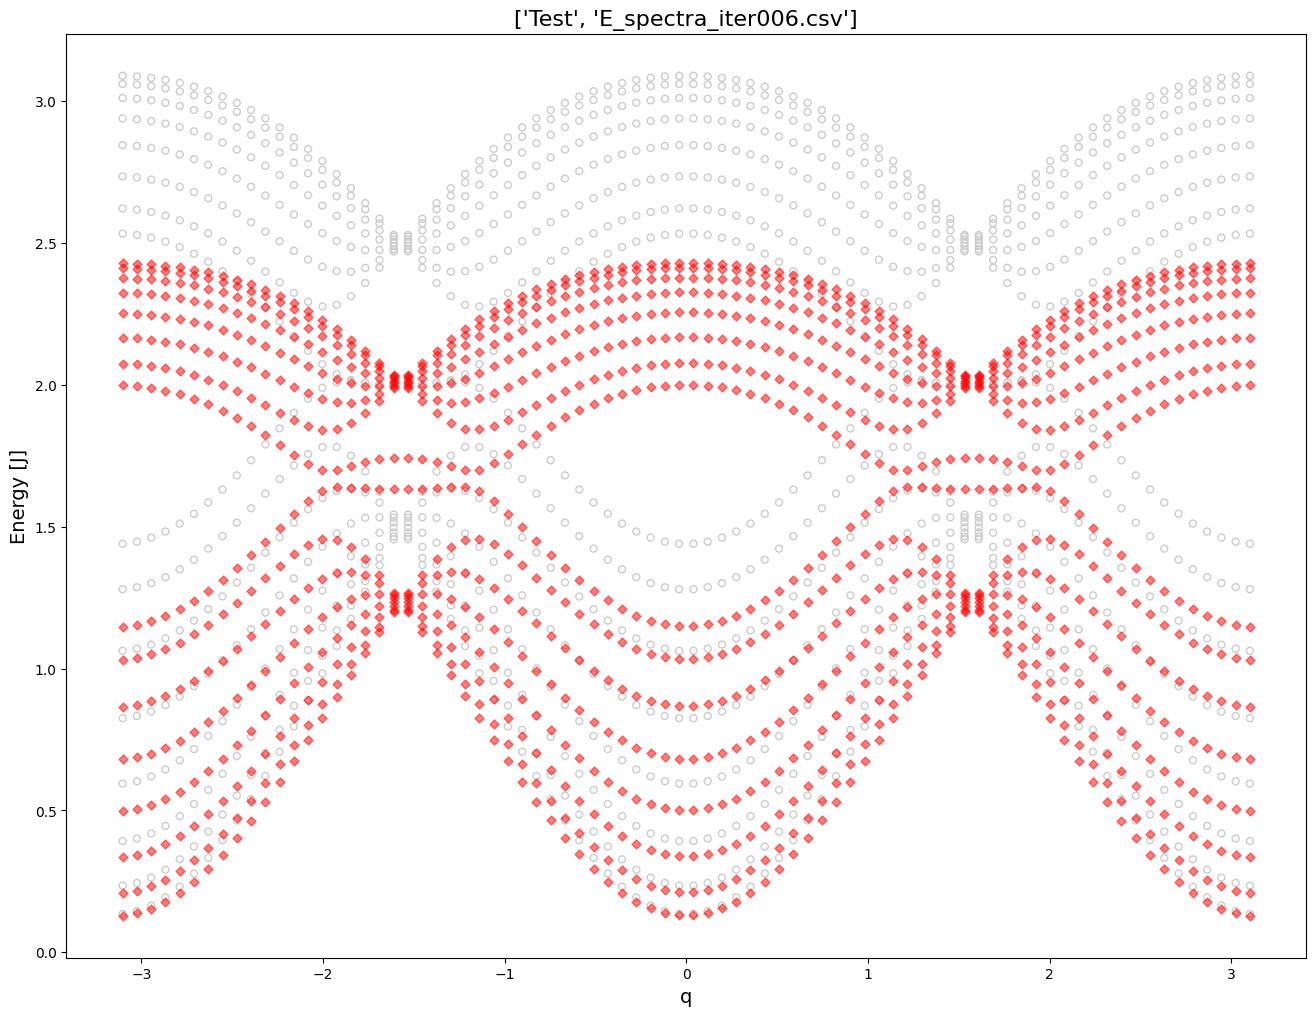

In [35]:
# T = 0.2
# j = 1.0
# J = 0.1
# d = 0.1
# h = 0.1
# Nq = 20
# Q, dQ = np.linspace(0, np.pi, Nq, endpoint=False, retstep=True)
# Q_m = Q + dQ/2
# Nq = 40*2
# Q, dQ = np.linspace(-np.pi, np.pi, Nq, endpoint=False, retstep=True)
# Q_m = Q + dQ/2
plot_spec(10, T, j, J, d, h, Q_m, 6)

In [28]:
A = np.array([[1, 2, 3+4j, 4, -1], [1, 2, 3+4j, 4, -1]])
B = np.array([[3, 5, 10, -2, 8], [1, 2, 3-4j, 4, -1]])
np.abs(A/B), np.sum(np.abs(A/B)), np.max(np.abs(A/B))

(array([[0.33333333, 0.4       , 0.5       , 2.        , 0.125     ],
        [1.        , 1.        , 1.        , 1.        , 1.        ]]),
 np.float64(8.358333333333334),
 np.float64(2.0))

# store

In [ ]:
def hamiltonian_0(j, J, d, h, k, obc=True):
    ''' H in A, B basis
    '''
    
    S = 0.5
    j, J, d = j*S, J*S, d*S
    
    ni = lambda i: i % N
    mat = np.zeros((N, N), dtype=np.complex64)
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)
        
    ''' Periodic boundary condition '''

    for i in A:
        
        mat[i, i] += 3*j + 6*J + h
        
        # nearest neighbors
        mat[i, ni(i+1)] += -2*j*np.cos(k)
        mat[i, ni(i-1)] += -j
        
        # next nearest neighbors
        mat[i, i] += -2*J*np.cos(2*k)
        mat[i, ni(i+2)] += -J*np.cos(k)
        mat[i, ni(i-2)] += -J*np.cos(k)
        mat[ni(i-2), i] += -J*np.cos(k)
        mat[ni(i+2), i] += -J*np.cos(k)
        # DMI
        mat[i, i] += -2*d*np.sin(2*k)
        mat[i, ni(i+2)] += d*np.sin(k)
        mat[i, ni(i-2)] += d*np.sin(k)
        mat[ni(i-2), i] += d*np.sin(k)
        mat[ni(i+2), i] += d*np.sin(k)
        
    for i in B:
        
        mat[i, i] = 3*j + 6*J + h
        
        # nearest neighbors
        mat[i, ni(i-1)] += -2*j*np.cos(k)
        mat[i, ni(i+1)] += -j
        
        # next nearest neighbors
        mat[i, i] += -2*J*np.cos(2*k)
        mat[i, ni(i+2)] += -J*np.cos(k)
        mat[i, ni(i-2)] += -J*np.cos(k)
        mat[ni(i-2), i] += -J*np.cos(k)
        mat[ni(i+2), i] += -J*np.cos(k)
        # DMI
        mat[i, i] += 2*d*np.sin(2*k)
        mat[i, ni(i+2)] += -d*np.sin(k)
        mat[i, ni(i-2)] += -d*np.sin(k)
        mat[ni(i-2), i] += -d*np.sin(k)
        mat[ni(i+2), i] += -d*np.sin(k)

    ''' Open boundary condition (in y direction)'''
    if obc:
        i = 0 # first layer
        mat[i, ni(0-1)] = 0
        mat[i, ni(0-2)] = 0
        
        i = 1 # second layer
        mat[i, ni(i-2)] = 0
        
        i = N-1 # last layer
        mat[i, ni(i+1)] = 0
        mat[i, ni(i+2)] = 0
            
        i = N-2 # second last layer
        mat[i, ni(i+2)] = 0
    else: pass
    
    return mat

def hamiltonian_mft(T, j, J, d, h, Q, obc=True, txtout=None):
    ''' H in u, d basis
    '''
    
    # Create directory to save data
    dir = f'/home/amos1/edgestate/data/T{T}_j{j}_J{J}_D{d}_h{h}_dkpm{len(Q)}/'
    os.makedirs(dir, exist_ok=True)
    
    # setup for iter = 0
    H_0 = np.zeros((len(Q), N, N), dtype = np.complex64)
    H_1 = np.zeros((len(Q), N, N), dtype = np.complex64)
    E_0 = np.zeros((len(Q), N), dtype = np.complex64) # eigenvalue spectra of previous iteration
    E = np.zeros((len(Q), N), dtype = np.complex64) # eigenvalue spectra of this iteration
    U = np.zeros((len(Q), N, N), dtype = np.complex64) # eigenvectors
    U_dag = np.zeros((len(Q), N, N), dtype = np.complex64) # conjugate transpose of U
    
    for i, kx in enumerate(Q):
        H_0_k = hamiltonian_0(j, J, d, h, kx, obc=obc)
        E_k, U_k, U_dag_k = eigenv(H_0_k)
        
        H_0[i, :, :] = H_0_k
        H_1[i, :, :] += U_dag[i, :, :] @ H_0[i, :, :] @ U[i, :, :] # 0th + 1st order H in u, d basis
        # E[i, :], U[i, :, :], U_dag[i, :, :] = eigenv(H_0)
        E_0[i, :] = E_k
        U[i, :, :] = U_k
        U_dag[i, :, :] = U_dag_k
    
    del H_0_k, E_k, U_k, U_dag_k
    
    data = pd.DataFrame(
        E_0.T, columns=[f'q_{i+1}' for i in range(Q.shape[0])]
    )
    data.to_csv(f'{dir}E_spectra_iter{0:03d}.csv', index=False)
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)

    deltak = np.pi / len(Q)
    
    # start iteration
    for iter in range(100):
        # add 2nd order matrix elements to H_1
        for q2 in range(len(Q)):
                
            def Vln(ii, jj): # V^{ln}_{ij;q2}: matrix element in u, d basis
                
                mat = np.zeros((N, N), dtype = np.complex64)
                if obc:
                    for l in range(N):
                        for n in range(N):
                            if ii < 0 or ii >= N or jj < 0 or jj >= N:
                                mat[l, n] = 0 # OBC
                            else: 
                                mat[l, n] += U_dag[q2, l, ii] * U[q2, jj, n]  
                else: 
                    for l in range(N):
                        for n in range(N):
                            mat[l, n] += U_dag[q2, l, ii % N] * U[q2, jj % N, n]
                
                return mat
                
            cosq2 = np.cos(Q[q2])
            
            for q1 in range(len(Q)):
                NB_k = 0
                for k in range(N):
                    NB_k += NB(T, E_0[q1, k]) * deltak / N
                
                for a in A:
                    # NN
                    H_1[q2, :, :] += (j*NB_k) * ( Vln(a-1, a)+Vln(a, a-1)-Vln(a, a)-Vln(a-1, a-1) )
                    H_1[q2, :, :] += 2*(j*NB_k) * ( cosq2*(Vln(a+1, a)+Vln(a, a+1))-Vln(a, a)-Vln(a+1, a+1) )
                    
                    # NNN
                    H_1[q2, :, :] += (J*NB_k) * ( cosq2*(Vln(a-2, a)+Vln(a, a-2))-Vln(a, a)-Vln(a-2, a-2) )
                    H_1[q2, :, :] += (J*NB_k) * ( cosq2*(Vln(a+2, a)+Vln(a, a+2))-Vln(a, a)-Vln(a+2, a+2) )
                    H_1[q2, :, :] += 2*(J*NB_k) * ( np.cos(2*Q[q2])+np.cos(2*Q[q1])-np.cos(Q[q2]-Q[q1])-1 )*Vln(a, a)
                    
                    # DMI
                    H_1[q2, :, :] += (d*NB_k) * np.sin(Q[q2])*( Vln(a-2, a)+Vln(a, a-2) )
                    H_1[q2, :, :] += (d*NB_k) * np.sin(Q[q2])*( Vln(a+2, a)+Vln(a, a+2) )
                    H_1[q2, :, :] += -2*(d*NB_k) * ( np.sin(2*Q[q2])+np.sin(2*Q[q1]) )*Vln(a, a)
                
                for b in B:
                    
                    # NNN
                    H_1[q2, :, :] += (J*NB_k) * ( cosq2*(Vln(b-2, b)+Vln(b, b-2))-Vln(b, b)-Vln(b-2, b-2) )
                    H_1[q2, :, :] += (J*NB_k) * ( cosq2*(Vln(b+2, b)+Vln(b, b+2))-Vln(b, b)-Vln(b+2, b+2) )
                    H_1[q2, :, :] += 2*(J*NB_k) * ( np.cos(2*Q[q2])+np.cos(2*Q[q1])-np.cos(Q[q2]-Q[q1])-1 )*Vln(b, b)
                    
                    # DMI
                    H_1[q2, :, :] -= (d*NB_k) * np.sin(Q[q2])*( Vln(b-2, b)+Vln(b, b-2) )
                    H_1[q2, :, :] -= (d*NB_k) * np.sin(Q[q2])*( Vln(b+2, b)+Vln(b, b+2) )
                    H_1[q2, :, :] -= -2*(d*NB_k) * ( np.sin(2*Q[q2])+np.sin(2*Q[q1]) )*Vln(b, b)
            # end of q1 sum
            
            H_D = U[q2, :, :] @ H_1[q2, :, :] @ U_dag[q2, :, :] # back to A, B basis
            E[q2, :], U[q2, :, :], U_dag[q2, :, :] = eigenv(H_D)
            del H_D
            H_1[q2, :, :] = U_dag[q2, :, :] @ H_0[q2, :, :] @ U[q2, :, :] # reset(update) H_1 for next iteration

        data = pd.DataFrame(
            E.T, columns=[f'q_{i+1}' for i in range(Q.shape[0])]
        )
        data.to_csv(f'{dir}E_spectra_iter{iter+1:03d}.csv', index=False)
        
        # if np.allclose(E, E_0, atol=1e-5):
        #     print(f'Converged at iteration {iter}.')
        #     break
        devi = np.sum(np.abs(E/E_0))/(N*len(Q)) - 1
        print(f'Iteration {iter} finished. Mean deviation: {devi/100}%')
        
        if iter>3:
            if np.any(np.abs(E/E_0)>1.01) or np.any(np.abs(E/E_0)<0.99):
                E_0 = E.copy()
                pass
            else:
                print(f'Converged at iteration {iter} with evolution < 1%.')
                break
        

(20, 10)

In [ ]:
def hamiltonian_0(j, J, d, h, k, obc=True):
    ''' H in A, B basis
    '''
    
    S = 0.5
    j, J, d = j*S, J*S, d*S
    
    ni = lambda i: i % N
    mat = np.zeros((N, N), dtype=np.complex64)
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)
        
    ''' Periodic boundary condition '''

    for i in A:
        
        mat[i, i] += 3*j + 6*J + h
        
        # nearest neighbors
        mat[i, ni(i+1)] += -2*j*np.cos(k)
        mat[i, ni(i-1)] += -j
        
        # next nearest neighbors
        mat[i, i] += -2*J*np.cos(2*k)
        mat[i, ni(i+2)] += -J*np.cos(k)
        mat[i, ni(i-2)] += -J*np.cos(k)
        mat[ni(i-2), i] += -J*np.cos(k)
        mat[ni(i+2), i] += -J*np.cos(k)
        # DMI
        mat[i, i] += -2*d*np.sin(2*k)
        mat[i, ni(i+2)] += d*np.sin(k)
        mat[i, ni(i-2)] += d*np.sin(k)
        mat[ni(i-2), i] += d*np.sin(k)
        mat[ni(i+2), i] += d*np.sin(k)
        
    for i in B:
        
        mat[i, i] = 3*j + 6*J + h
        
        # nearest neighbors
        mat[i, ni(i-1)] += -2*j*np.cos(k)
        mat[i, ni(i+1)] += -j
        
        # next nearest neighbors
        mat[i, i] += -2*J*np.cos(2*k)
        mat[i, ni(i+2)] += -J*np.cos(k)
        mat[i, ni(i-2)] += -J*np.cos(k)
        mat[ni(i-2), i] += -J*np.cos(k)
        mat[ni(i+2), i] += -J*np.cos(k)
        # DMI
        mat[i, i] += 2*d*np.sin(2*k)
        mat[i, ni(i+2)] += -d*np.sin(k)
        mat[i, ni(i-2)] += -d*np.sin(k)
        mat[ni(i-2), i] += -d*np.sin(k)
        mat[ni(i+2), i] += -d*np.sin(k)

    ''' Open boundary condition (in y direction)'''
    if obc:
        i = 0 # first layer
        mat[i, ni(0-1)] = 0
        mat[i, ni(0-2)] = 0
        
        i = 1 # second layer
        mat[i, ni(i-2)] = 0
        
        i = N-1 # last layer
        mat[i, ni(i+1)] = 0
        mat[i, ni(i+2)] = 0
            
        i = N-2 # second last layer
        mat[i, ni(i+2)] = 0
    else: pass
    
    return mat

def hamiltonian_mft(iteration, T, j, J, d, h, Q, obc=True, txtout=None):
    ''' H in u, d basis
    '''
    
    # Create directory to save data
    dir = f'/home/amos1/edgestate/data/T{T}_j{j}_J{J}_D{d}_h{h}_dk{len(Q)}_pbc/'
    os.makedirs(dir, exist_ok=True)
    
    # setup for iter = 0
    H_0 = np.zeros((len(Q), N, N), dtype = np.complex64)
    H_1 = np.zeros((len(Q), N, N), dtype = np.complex64)
    E = np.zeros((len(Q), N), dtype = np.complex64) # eigenvalue spectra
    U = np.zeros((len(Q), N, N), dtype = np.complex64) # eigenvectors
    U_dag = np.zeros((len(Q), N, N), dtype = np.complex64) # conjugate transpose of U
    
    for i, kx in enumerate(Q):
        H_0_k = hamiltonian_0(j, J, d, h, kx, obc=obc)
        E_k, U_k, U_dag_k = eigenv(H_0_k)
        
        H_0[i, :, :] = H_0_k
        H_1[i, :, :] += U_dag[i, :, :] @ H_0[i, :, :] @ U[i, :, :] # 0th + 1st order H in u, d basis
        # E[i, :], U[i, :, :], U_dag[i, :, :] = eigenv(H_0)
        E[i, :] = E_k
        U[i, :, :] = U_k
        U_dag[i, :, :] = U_dag_k
    
    del H_0_k, E_k, U_k, U_dag_k
    
    data = pd.DataFrame(
        E.T, columns=[f'q_{i+1}' for i in range(Q.shape[0])]
    )
    data.to_csv(f'{dir}E_spectra_iter{0:03d}.csv', index=False)
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)

    deltak = np.pi / len(Q)
    
    # start iteration
    for iter in range(iteration):
        # add 2nd order matrix elements to H_1
        for q2 in range(len(Q)):
                
            def Vln(ii, jj): # V^{ln}_{ij;q2}: matrix element in u, d basis
                
                mat = np.zeros((N, N), dtype = np.complex64)
                if obc:
                    for l in range(N):
                        for n in range(N):
                            if ii < 0 or ii >= N or jj < 0 or jj >= N:
                                mat[l, n] = 0 # OBC
                            else: 
                                mat[l, n] += U_dag[q2, l, ii] * U[q2, jj, n]  
                else: 
                    for l in range(N):
                        for n in range(N):
                            mat[l, n] += U_dag[q2, l, ii % N] * U[q2, jj % N, n]
                
                return mat
                
            cosq2 = np.cos(Q[q2])
            
            NB_q = 0
            for q1 in range(len(Q)):
                Jii = 0
                Dii = 0
                NB_q1 = 0
                for k in range(N):
                    NB_q1 += NB(T, E[q1, k]) * deltak / N
                    NB_q += NB(T, E[q1, k]) * deltak / N
                
                Jii += 2*(J*NB_q1) * ( np.cos(2*Q[q2])+np.cos(2*Q[q1])-np.cos(Q[q2]-Q[q1])-1 )
                Dii += -2*(d*NB_q1) * ( np.sin(2*Q[q2])+np.sin(2*Q[q1]) )
                
            for a in A:
                # NN
                H_1[q2, :, :] += (j*NB_q) * ( Vln(a-1, a)+Vln(a, a-1)-Vln(a, a)-Vln(a-1, a-1) )
                H_1[q2, :, :] += 2*(j*NB_q) * ( cosq2*(Vln(a+1, a)+Vln(a, a+1))-Vln(a, a)-Vln(a+1, a+1) )
                
                # NNN
                H_1[q2, :, :] += (J*NB_q) * ( cosq2*(Vln(a-2, a)+Vln(a, a-2))-Vln(a, a)-Vln(a-2, a-2) )
                H_1[q2, :, :] += (J*NB_q) * ( cosq2*(Vln(a+2, a)+Vln(a, a+2))-Vln(a, a)-Vln(a+2, a+2) )
                H_1[q2, :, :] += Jii*Vln(a, a)
                
                # DMI
                H_1[q2, :, :] += (d*NB_q) * np.sin(Q[q2])*( Vln(a-2, a)+Vln(a, a-2) )
                H_1[q2, :, :] += (d*NB_q) * np.sin(Q[q2])*( Vln(a+2, a)+Vln(a, a+2) )
                H_1[q2, :, :] += Dii*Vln(a, a)
            
            for b in B:
                
                # NNN
                H_1[q2, :, :] += (J*NB_q) * ( cosq2*(Vln(b-2, b)+Vln(b, b-2))-Vln(b, b)-Vln(b-2, b-2) )
                H_1[q2, :, :] += (J*NB_q) * ( cosq2*(Vln(b+2, b)+Vln(b, b+2))-Vln(b, b)-Vln(b+2, b+2) )
                H_1[q2, :, :] += Jii*Vln(b, b)
                
                # DMI
                H_1[q2, :, :] -= (d*NB_q) * np.sin(Q[q2])*( Vln(b-2, b)+Vln(b, b-2) )
                H_1[q2, :, :] -= (d*NB_q) * np.sin(Q[q2])*( Vln(b+2, b)+Vln(b, b+2) )
                H_1[q2, :, :] -= Dii*Vln(b, b)
            
            H_D = U[q2, :, :] @ H_1[q2, :, :] @ U_dag[q2, :, :] # back to A, B basis
            E[q2, :], U[q2, :, :], U_dag[q2, :, :] = eigenv(H_D)
            del H_D
            H_1[q2, :, :] = U_dag[q2, :, :] @ H_0[q2, :, :] @ U[q2, :, :] # reset(update) H_1 for next iteration

        data = pd.DataFrame(
            E.T, columns=[f'q_{i+1}' for i in range(Q.shape[0])]
        )
        data.to_csv(f'{dir}E_spectra_iter{iter+1:03d}.csv', index=False)
    
        print(f'Iteration {iter} finished.')
        
        # with open(f'./H{T}{jn}{J}{d}.txt', 'a') as f:
        #     f.write(f'Iteration {iter} H matrix:\n')
        #     for i in range(N):
        #         for j in range(N):
        #             f.write('{0:.4f},'.format(np.real(H[i, j])))
        #         f.write('\n')

In [20]:
import numpy as np
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
B = np.array([[-1.1, 2, 3], [4, 5, 6], [7, 8, 9]])
C = B/A
if np.any(np.abs(C)>1):
    print('1')

1


In [19]:
C

array([[-1.1,  1. ,  1. ],
       [ 1. ,  1. ,  1. ],
       [ 1. ,  1. ,  1. ]])

In [15]:
np.sum(C)

np.float64(9.05)